# Notebook Purpose

Exploring what the network has learned. Confusion matrices, failure case visualization etc.

In [1]:
#!/usr/bin/env python
from __future__ import print_function, division
# coding: utf-8

# In[1]:


import torch
import sys

# from torchvision import datasets, models, transforms

from PIL import Image
import torchvision

sys.path.append('/om5/user/smadan/training_scaffold_own/res/')
from models.models import get_model
from loader.loader import get_loader
import random
import pickle
import argparse

/net/storage001.ib.cluster/om2/user/smadan/differentiable_graphics_ml/training_models
/om5/user/smadan/training_scaffold_own/res/loader/multi_attribute_loader.py
/om5/user/smadan/training_scaffold_own/res/loader
/om5/user/smadan/training_scaffold_own/res/loader/loader.py
/om5/user/smadan/training_scaffold_own/res/loader


In [2]:
wandb_config = {}
wandb_config['dataset_name'] = 'shapenet_hand_picked'
wandb_config['batch_size'] = 10
wandb_config['model_path'] = '/om5/user/smadan/differentiable_graphics_ml/training_models/saved_models/resnet_10_models_00001_2'

In [3]:
# LOG_FILE_HANDLE = open(LOG_FILE, 'w')

loader = get_loader('multi_attribute_loader_file_list_shapenet')



# In[4]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import collections
from collections import OrderedDict
from tqdm import tqdm

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

loader_new = get_loader('multi_attribute_loader_file_list_shapenet')
file_list_root = '/om5/user/smadan/dataset_lists_openmind'
att_path = '/om5/user/smadan/differentiable_graphics_ml/training_models/shapenet_id_to_class_num.p'
shuffles = {'train':True,'val':True,'test':False}

# if wandb_config['use_gpu']:
#     torch.cuda.set_device(0)

count=0

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

file_lists = {}
dsets = {}
dset_loaders = {}
dset_sizes = {}
for phase in ['train','test']:
    file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,wandb_config['dataset_name'])
    dsets[phase] = loader_new(file_lists[phase],att_path, image_transform)
    dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=wandb_config['batch_size'], shuffle = shuffles[phase], num_workers=2,drop_last=True)
    dset_sizes[phase] = len(dsets[phase])

In [4]:
with open(wandb_config['model_path'],'rb') as F:
    loaded_model = torch.load(F)

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalize = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [6]:
with open('shapenet_class_num_to_class_name.p','rb') as F:
    shapenet_class_num_to_class_name = pickle.load(F)

In [7]:
wrong_images = np.zeros((10000, 224,224,3))
wrong_preds = np.zeros((10000))
wrong_gts = np.zeros((10000))

In [8]:
iters = 0
wrong_count = 0
for data in dset_loaders['test']:
    if iters % 50 == 0:
        print(iters)
    inputs, labels, _ = data
    inputs = inputs.cuda()
    outputs = loaded_model(inputs)
    preds = torch.argmax(outputs, dim = 1)
    for i in range(len(preds)):
        if preds[i] != labels[i]:
            input_img = unnormalize(inputs[i].permute(1,2,0)).cpu()
            wrong_images[wrong_count] = input_img
            wrong_preds[wrong_count] = preds[i].item()
            wrong_gts[wrong_count] = labels[i].item()
            wrong_count += 1
    iters += 1

0
50
100
150


In [19]:
# preds

In [10]:
wrong_count

513

In [11]:
chosen_indices = random.sample(range(wrong_count),25)

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


In [14]:
wrong_count

513

In [15]:
error_images = wrong_images[:wrong_count]
error_preds = wrong_preds[:wrong_count].astype('int')
error_gts = wrong_gts[:wrong_count].astype('int')

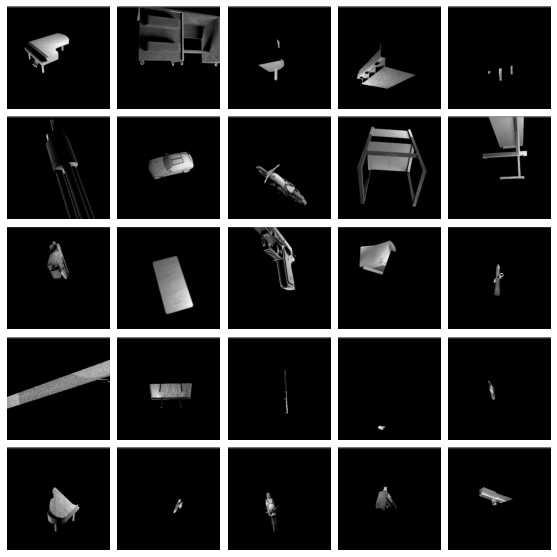

In [17]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, error_images[chosen_indices]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

In [69]:
confusion_matrix = np.zeros((55,55)).astype('int')

In [70]:
for i in range(wrong_count):
    confusion_matrix[error_gts[i], error_preds[i]] += 1

In [71]:
existing = np.unique(error_gts)

In [76]:
for cat in existing:
    cat_name = shapenet_class_num_to_class_name[cat]
    confusions = int(np.sum(confusion_matrix[cat]))
    max_confused = np.argmax(confusion_matrix[cat])
    max_confused_name = shapenet_class_num_to_class_name[max_confused]
    print("%s: error count: %s, Most Confused with: %s (%s)"%(cat_name, confusions, max_confused_name, confusion_matrix[cat, max_confused]))

airplane,aeroplane,plane: error count: 9, Most Confused with: knife (3)
bed: error count: 62, Most Confused with: sofa,couch,lounge (38)
car,auto,automobile,machine,motorcar: error count: 42, Most Confused with: piano,pianoforte,forte-piano (9)
chair: error count: 52, Most Confused with: sofa,couch,lounge (17)
guitar: error count: 27, Most Confused with: knife (15)
knife: error count: 22, Most Confused with: guitar (11)
motorcycle,bike: error count: 26, Most Confused with: knife (8)
piano,pianoforte,forte-piano: error count: 82, Most Confused with: table (26)
pistol,handgun,side arm,shooting iron: error count: 64, Most Confused with: airplane,aeroplane,plane (17)
sofa,couch,lounge: error count: 70, Most Confused with: bed (21)
table: error count: 57, Most Confused with: piano,pianoforte,forte-piano (14)
